# Stroke Prediction using Random Forest

The goal of this project is to build a random forest model that would predict the patients with high risk and have higher chance of stroke. This helps in providing the advanced warning to alert the patients so that theey can apply proper precautions and possibly the prevent the stroke.

In [43]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas_profiling as pp
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

Load inputdata

In [23]:
# read file and load into a dataframe
df = pd.read_csv('Data/healthcare-dataset-stroke-data.csv')
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [11]:
# Show the sample data
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [13]:
# Show the values for few features to get an understanding of the data
columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for column in columns:
    print(f'Possible values for {column}:\n{df["gender"].value_counts()}\n')

Possible values for gender:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Possible values for ever_married:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Possible values for work_type:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Possible values for Residence_type:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Possible values for smoking_status:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64



In [24]:
# Now modify the categorical values into numeric format
change_cat = { "gender": {"Male": '1', "Female": '2'},
              "ever_married": {"Yes": '1', "No": '0'},
              "work_type": {"Private": '1', "Self-employed": '2', "children": '3',
                            "Govt_job": '4', "Never_worked" : '5'},
              "Residence_type": {"Urban": '1', "Rural": '2'},
              "smoking_status": {"never smoked": '1', "Unknown": '2', "formerly smoked": '3',
                               "smokes": '4'}
             }

# Replace categorical values on pandas dataframe to numerical values
df = df.replace(change_cat)

# Display the updated sample data
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,1,1,228.69,36.6,3,1
1,51676,2,61.0,0,0,1,2,2,202.21,NaN,1,1
2,31112,1,80.0,0,1,1,1,2,105.92,32.5,1,1
3,60182,2,49.0,0,0,1,1,1,171.23,34.4,4,1
4,1665,2,79.0,1,0,1,2,2,174.12,24.0,1,1


In [16]:
# Print the Pandas dataframe profile
profile = pp.ProfileReport(df)
profile.to_file("df_profile.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 56.66it/s]


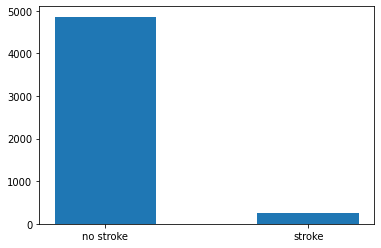

In [19]:
# Show the plot for number of stroke patients vs. no stroke patients in the dataset
x_class = df['stroke'].value_counts()
plt.bar(x=['no stroke', 'stroke'], height = x_class, width = 0.5)
plt.show()

In [25]:
# Handle missing values
print(f'Before handling missing values:\n{df.isna().sum()}')

# fill the missing values
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

print(f'\nAfter handling missing values:\n{df.isna().sum()}')

Before handling missing values:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

After handling missing values:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [27]:
# Drop id value as it won't help us with prediction
df2 = df.drop(['id'], axis=1)
df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,1,1,228.69,36.600000,3,1
1,2,61.0,0,0,1,2,2,202.21,28.893237,1,1
2,1,80.0,0,1,1,1,2,105.92,32.500000,1,1
3,2,49.0,0,0,1,1,1,171.23,34.400000,4,1
4,2,79.0,1,0,1,2,2,174.12,24.000000,1,1


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


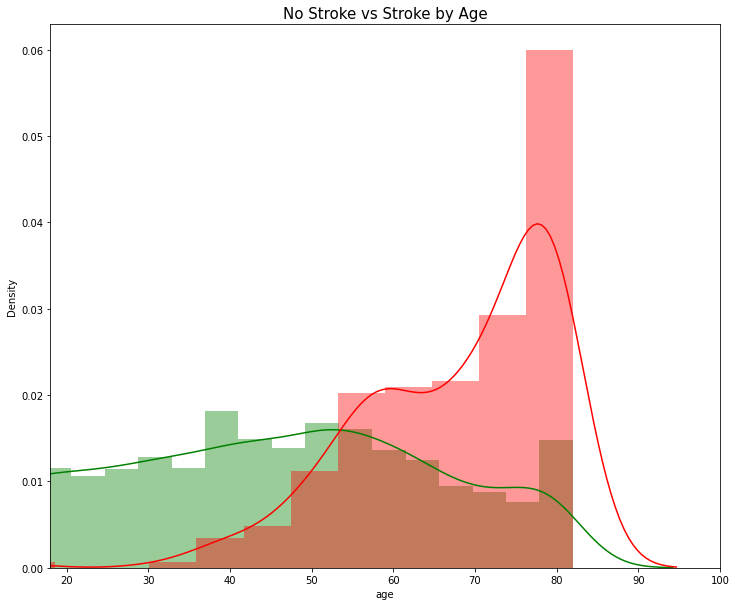

In [28]:
# Stroke distribution by age Age
plt.figure(figsize=(12,10))

sns.distplot(df2[df2['stroke'] == 0]["age"], color='green') # No Stroke - green
sns.distplot(df2[df2['stroke'] == 1]["age"], color='red') # Stroke - Red

plt.title('No Stroke vs Stroke by Age', fontsize=15)
plt.xlim([18,100])
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


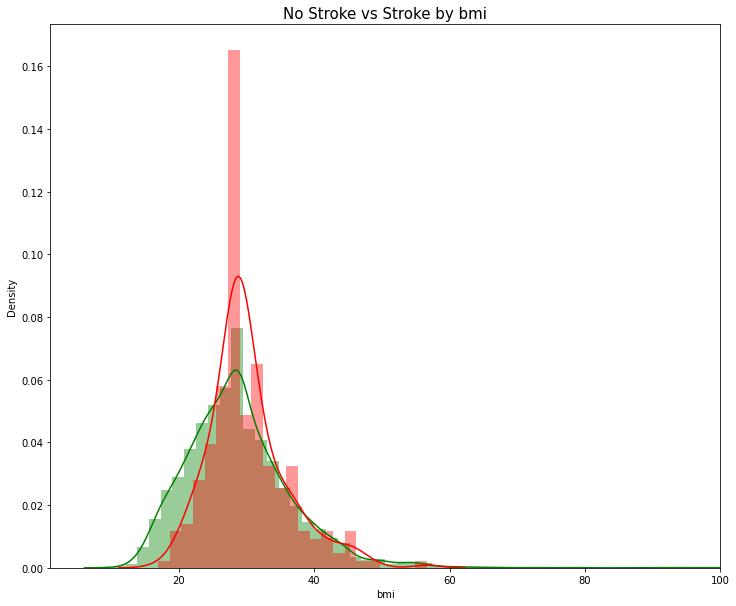

In [29]:
# Stroke distribution by bmi
plt.figure(figsize=(12,10))

sns.distplot(df2[df2['stroke'] == 0]["bmi"], color='green') # No Stroke - green
sns.distplot(df2[df2['stroke'] == 1]["bmi"], color='red') # Stroke - Red

plt.title('No Stroke vs Stroke by bmi', fontsize=15)
plt.xlim([1,100])
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


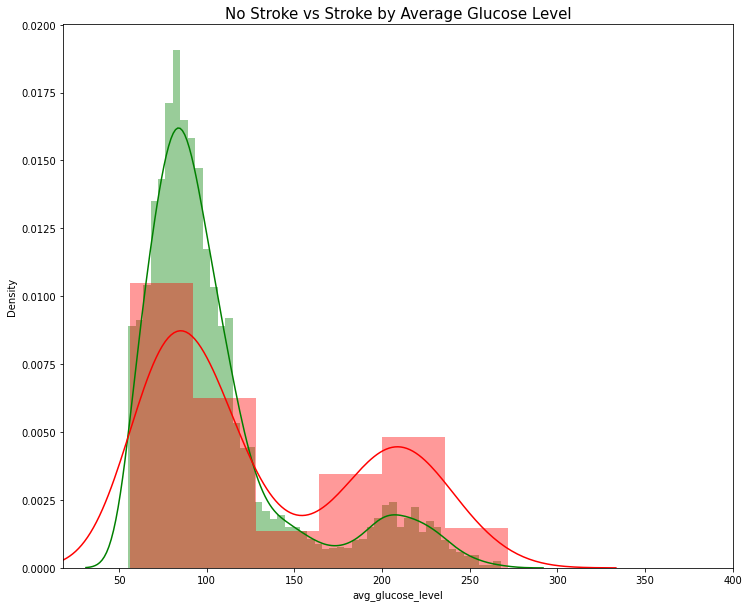

In [30]:
# Stroke distribution by glucose level
plt.figure(figsize=(12,10))

sns.distplot(df2[df2['stroke'] == 0]["avg_glucose_level"], color='green') # No Stroke - green
sns.distplot(df2[df2['stroke'] == 1]["avg_glucose_level"], color='red') # Stroke - Red

plt.title('No Stroke vs Stroke by Average Glucose Level', fontsize=15)
plt.xlim([18,400])
plt.show()

#### Handle outliers in the data

In [32]:
# handle outlier data for stroke data
temp_df1= df2[df2.stroke == 1]   # stroke

# prior to removing stroke outlier
print(f'Shape of the dataset before handling stroke outliers: {temp_df1.shape}')

# We will consider outlier is zscore is > 3 or < -3 and remove all of them
zscore_glucose = stats.zscore(temp_df1.avg_glucose_level) # calculate zscore 
temp_df1 = temp_df1[(abs(zscore_glucose) < 3)] # drop rows with zscore > 3 or < -3

zscore_bmi = stats.zscore(temp_df1.bmi) # calculate zscore 
temp_df1 = temp_df1[(abs(zscore_bmi) < 3)] # drop rows with zscore > 3 or < -3

# After removing stroke outlier
print(f'Shape of the dataset after handling stroke outliers: {temp_df1.shape}')

Shape of the dataset before handling stroke outliers: (249, 11)
Shape of the dataset after handling stroke outliers: (247, 11)


In [33]:
# handle outlier data for no-stroke data
temp_df0= df2[df2.stroke == 0]   # no-stroke

# prior to removing stroke outlier
print(f'Shape of the dataset before handling stroke outliers: {temp_df0.shape}')

# We will consider outlier is zscore is > 3 or < -3 and remove all of them
zscore_glucose = stats.zscore(temp_df0.avg_glucose_level) # calculate zscore 
temp_df0 = temp_df0[(abs(zscore_glucose) < 3)] # drop rows with zscore > 3 or < -3

zscore_bmi = stats.zscore(temp_df0.bmi) # calculate zscore 
temp_df0 = temp_df0[(abs(zscore_bmi) < 3)] # drop rows with zscore > 3 or < -3

# After removing stroke outlier
print(f'Shape of the dataset after handling stroke outliers: {temp_df0.shape}')

Shape of the dataset before handling stroke outliers: (4861, 11)
Shape of the dataset after handling stroke outliers: (4743, 11)


In [34]:
# combine stroke & no-stroke data after removing outliers
df3 = pd.concat([temp_df1, temp_df0], axis=0, sort=False)  # concatenate both Classes
df3.shape

(4990, 11)

### One hot encoding for modeling

In [35]:
# hot encoding
X = df3.drop('stroke', axis=1)  # get only independent variables
y = df3['stroke']  # get output variable

num_cols = X.select_dtypes(include = ['int64', 'float64']).columns.to_list()
cat_cols = X.select_dtypes(include = ['object']).columns.to_list()

def label_encoder(df):
    for i in cat_cols:
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
    return df


# robust scaler
rs = RobustScaler()
X[num_cols] = rs.fit_transform(X[num_cols])

# Label encoding
X = label_encoder(X)

X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0,0.638889,0.0,1.0,1,0,0,3.845550,0.932584,2
1,1,0.472222,0.0,0.0,1,1,1,3.103294,0.066656,0
2,0,1.000000,0.0,1.0,1,0,1,0.404205,0.471910,0
3,1,0.138889,0.0,0.0,1,0,0,2.234898,0.685393,3
4,1,0.972222,1.0,0.0,1,1,1,2.315907,-0.483146,0


In [37]:
# Train Test Split
seed = 824
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.25, random_state=seed)

In [40]:
# over sample the minority class
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

### Build the Random Forest model

In [41]:
# Build Random Forest grid for modeling

params = {'n_estimators': [50, 100, 150, 200],
          'max_depth': [10,20,30,40,50],
          'max_features': ['sqrt', 'log2'],
          'class_weight': ['balanced', None],
           'bootstrap': [True, False]}


rf_grid = GridSearchCV(RandomForestClassifier(random_state=seed),
                       param_grid=params,
                       scoring={'avr': make_scorer(average_precision_score, needs_proba=True),
                                'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
                       n_jobs=-1,
                       cv=5,
                       refit='avr')

In [42]:
# Train the model
rf_grid.fit(X_train_balanced, y_train_balanced)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=824),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced', None],
                         'max_depth': [10, 20, 30, 40, 50],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 150, 200]},
             refit='avr',
             scoring={'avr': make_scorer(average_precision_score, needs_proba=True),
                      'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)})

In [44]:
rf_grid.best_score_, rf_grid.best_params_

(0.9903014311205866,
 {'bootstrap': False,
  'class_weight': 'balanced',
  'max_depth': 20,
  'max_features': 'sqrt',
  'n_estimators': 200})

In [47]:
# get f1 matrix after predicting the test set
y_pred = rf_grid.predict(X_test)
target_names = ['no-stroke', 'stroke']
print(classification_report(y_test, y_pred, target_names=target_names))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

              precision    recall  f1-score   support

   no-stroke       0.96      0.95      0.95      1186
      stroke       0.17      0.21      0.19        62

    accuracy                           0.91      1248
   macro avg       0.56      0.58      0.57      1248
weighted avg       0.92      0.91      0.91      1248

0.9094551282051282
0.16883116883116883
0.20967741935483872
0.18705035971223022


In [48]:
# COnfusion Matrix
confusion_matrix(y_test, y_pred)

array([[1122,   64],
       [  49,   13]])

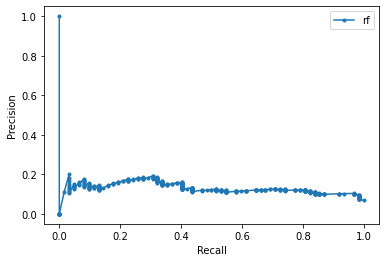

In [46]:
# plot precision recall curve

# predict probabilities
yhat = rf_grid.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='rf')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [49]:
average_precision = average_precision_score(y_test, pos_probs)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.13


Conclusion:
- Based on the accuracy, precision score, and precision-recall scores, random forest model seem to have performed really well in stroke prediction.

References:
- https://www.kaggle.com/fedesoriano/stroke-prediction-dataset